### Modélisation

Après avoir procéder à l'EDA et à la création de nos jeux de données train et test, nous pouvons passer à l'étape de modélisation.


In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import clone

In [3]:
import sys
!{sys.executable} -m pip install mlflow
import mlflow


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [14]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("file:///Users/kseniadautel/projet_mlops/mlruns")
mlflow.set_experiment("home-credit-scoring")

/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/02 14:52:14 INFO mlflow.tracking.fluent: Experiment with name 'home-credit-scoring' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/kseniadautel/projet_mlops/mlruns/773257526719598066', creation_time=1770040334286, experiment_id='773257526719598066', last_update_time=1770040334286, lifecycle_stage='active', name='home-credit-scoring', tags={}>

In [ ]:
from pathlib import Path
MODEL_URI = "models:LXGBoost_Home_Credit_Scoring/1"
OUT = Path("models/xgb_model")

In [5]:
train = pd.read_csv('../data/processed/train_final.csv')
test = pd.read_csv('../data/processed/test_final.csv')

print (train.shape, test.shape)

(307505, 514) (48744, 513)


In [6]:
# split features/target
X = train.drop(columns=['TARGET']).copy()
y = train['TARGET'].copy()

In [7]:
X.shape

(307505, 513)

In [8]:
X = X.drop(columns=["SK_ID_CURR"])

In [9]:
# SK_ID_CURR pour retrouver les clients
sk_id = train["SK_ID_CURR"].copy()

Préprocessing (num + cat) et (Pipeline)

In [10]:
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()

print (f"Numeric: {len(num_cols)}, Categorival: {len(cat_cols)}")

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
    ], remainder='drop')




Numeric: 490, Categorival: 22


### **Fonction de coût métier + seuil optimal**

target = 1 = default (mauvaise client)

FN : mauvais client prédit bon (coût 10)

FP : bon client prédit mauvais (coût 1)


In [63]:
def business_cost(y_true, y_pred, fn_cost=10, fp_cost=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return float(fn * fn_cost + fp * fp_cost)

In [64]:
def best_threshold(y_true, y_proba, fn_cost=10, fp_cost=1, n=200):
    thresholds = np.linspace(0, 1, n)
    best_t, best_c = 0.5, np.inf
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        cost = business_cost(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost)
        if cost < best_c:
            best_c, best_t = cost, float(t)
    return best_t, best_c

### Évaluation CV (StratifiedKFold) + métriques

In [65]:
def cv_evaluate_model(model, X, y, preprocessor, n_splits=5, random_state=42, fn_cost=10, fp_cost=1, show_cm=False):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    row = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipe = Pipeline(steps=[
            ('preprocessor', clone(preprocessor)),
            ('model', clone(model))
        ])
        pipe.fit(X_train, y_train)

        # probabilities for the positive class
        y_proba = pipe.predict_proba(X_val)[:, 1]
        # find best threshold minimizing business cost
        best_t, best_c = best_threshold(y_val, y_proba, fn_cost=fn_cost, fp_cost=fp_cost)

        # métriques au seuil optimal
        y_pred = (y_proba >= best_t).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        
        if show_cm:
            print(f"\nFold {fold} Confusion Matrix at best threshold {best_t:.3f} (business cost: {best_c:.0f})")
            print(confusion_matrix(y_val, y_pred))
            print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

        row.append({
            "fold": fold,
            "best threshold": best_t,
            "business cost": best_c,
            "roc_auc": roc_auc_score(y_val, y_proba),
            "accuracy": accuracy_score(y_val, y_pred),
            "recall": recall_score(y_val, y_pred),
            "f1_score": f1_score(y_val, y_pred),
            "fp": float(fp),
            "fn": float(fn)
        })

    results = pd.DataFrame(row)

    return results, results.mean(numeric_only=True)

### Creation de la fonctin MLflow ( 1 run par modèle avec CV )

In [15]:
def mlflow_log_cv_results(model_name, model, preprocessor, X, y, n_splits=5, random_state=42, fn_cost=10, fp_cost=1, tags=None, params=None):
    """ Lance une évaluation CV du modèle et logge les résultats dans MLflow """
    with mlflow.start_run(run_name=model_name):
        # Tags
        mlflow.set_tags({
            "model_name": model_name,
            "cv": f"StratifiedKFold_{n_splits}",
            "data_scoope": "sample_set_50K",
            "fn_cost": str(fn_cost),
            "fp_cost": str(fp_cost),
            **(tags or {})
        }) 
        # Paramétres du modèle
        if params:
            mlflow.log_params(params)
            
        # Évaluation CV
        results, mean_results = cv_evaluate_model(model, X, y, preprocessor,
                                                  n_splits=n_splits,
                                                  random_state=random_state,
                                                  fn_cost=fn_cost,
                                                  fp_cost=fp_cost)
        # Log métriques
        mlflow.log_metrics({
            "mean_business_cost": float(mean_results["business cost"]),
            "mean_roc_auc": float(mean_results["roc_auc"]),
            "mean_accuracy": float(mean_results["accuracy"]),
            "mean_recall": float(mean_results["recall"]),
            "mean_f1_score": float(mean_results["f1_score"]),
            "mean_fn": float(mean_results["fn"]),
            "mean_fp": float(mean_results["fp"]),
            "mean_best_threshold": float(mean_results["best threshold"])
        })
        
        # Log table CV results
        tmp_path = f"{model_name}_cv_results.csv"
        results.to_csv(tmp_path, index=False)
        mlflow.log_artifact(tmp_path, artifact_path="cv_results")

        return results, mean_results

### Création d'échantillons pour les divers tests d'algorithmes

In [16]:
X_sample_set, _, y_sample_set, _ = train_test_split(X, y, train_size=50000, stratify=y, random_state=42) 

In [17]:
X_sample_set.shape, y_sample_set.shape

((50000, 512), (50000,))

### Model 1: Logistic Regression

In [18]:
results, mean_results = mlflow_log_cv_results(
    model_name="Logistic_Regression_sample_set",
    model=LogisticRegression(class_weight='balanced', n_jobs=None, random_state=42, C = 0.0001),
    preprocessor=preprocessor,
    X=X_sample_set,
    y=y_sample_set,
    n_splits=3,
    tags={"model_type": "logistic_regression", "dataset": "sample_set_50000"},
    params={"C": 0.0001, "class_weight": "balanced", "solver":"saga"}
)

### Modèle 2: Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)

results_rf, mean_results_rf = cv_evaluate_model(rf, X, y, preprocessor, n_splits=5, random_state=42, fn_cost=10, fp_cost=1)
print("Random Forest CV Results:")
display(results_rf)
print("\nMean CV Results:")
display(mean_results_rf)


2026/01/08 10:44:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '39bf56dde842475eb44d5109392fe233', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2026/01/08 10:44:31 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler(with_mean=False))]), ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_N

🏃 View run adaptable-panda-456 at: http://127.0.0.1:5000/#/experiments/1/runs/39bf56dde842475eb44d5109392fe233
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2026/01/08 10:50:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/08 10:50:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9656c9940d504f37898799f282035ff3', w

🏃 View run angry-gnu-505 at: http://127.0.0.1:5000/#/experiments/1/runs/9656c9940d504f37898799f282035ff3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2026/01/08 10:55:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/08 10:55:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '310cdfe7dac04379b420bc7b2446b5c2', w

🏃 View run rare-panda-519 at: http://127.0.0.1:5000/#/experiments/1/runs/310cdfe7dac04379b420bc7b2446b5c2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2026/01/08 11:00:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/08 11:00:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'baee14fc2e854722b5e81c70bcb027f4', w

🏃 View run lyrical-crane-199 at: http://127.0.0.1:5000/#/experiments/1/runs/baee14fc2e854722b5e81c70bcb027f4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2026/01/08 11:06:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/08 11:06:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eb11e5f6f8a84b47b8203e755a113d35', w

🏃 View run amusing-mole-999 at: http://127.0.0.1:5000/#/experiments/1/runs/eb11e5f6f8a84b47b8203e755a113d35
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2026/01/08 11:11:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Random Forest CV Results:


,fold,best threshold,business cost,roc_auc,accuracy,recall,f1_score
0,1,0.095477,32703,0.754566,0.733273,0.635247,0.277739
1,2,0.090452,32942,0.753653,0.714021,0.656395,0.270389
2,3,0.095477,32788,0.751566,0.733354,0.633233,0.277163
3,4,0.090452,32255,0.756916,0.719045,0.664854,0.276454
4,5,0.090452,33344,0.749837,0.715826,0.644914,0.268163



Mean CV Results:


fold                  3.000000
best threshold        0.092462
business cost     32806.400000
roc_auc               0.753307
accuracy              0.723104
recall                0.646928
f1_score              0.273982
dtype: float64

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)

In [20]:
results_rf, mean_results_rf = mlflow_log_cv_results(
    model_name="Random_Forest_sample_set",
    model=rf,
    preprocessor=preprocessor,
    X=X_sample_set,
    y=y_sample_set,
    n_splits=3,
    random_state=42,
    tags={"model_type": "random_forest"},
    params={"n_estimators": 300, "max_depth": None, "class_weight":"balanced_subsample"}
)
    

### Modél 3: XGBoost

In [21]:
from xgboost import XGBClassifier

# avec déséquilibre des classes géré via scale_pos_weight
scale_pos_weight = (y_sample_set == 0).sum() / (y_sample_set == 1).sum()

xgb = XGBClassifier(
    n_estimators = 500,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist'
)

In [22]:
results_xgb, mean_results_xgb = mlflow_log_cv_results(
    model_name="XGBoost_sample_set",
    model=xgb,
    preprocessor=preprocessor,
    X=X_sample_set,
    y=y_sample_set,
    n_splits=3,
    tags={"model_type": "xgboost", "scale_pos_weight": str(scale_pos_weight), "data_scope": "sample_set_50K"},
    params={"n_estimators": 500, "max_depth": 4, "scale_pos_weight": scale_pos_weight, "learning_rate": 0.05, "subsample":0.8, "colsample_bytree":0.8,
            "tree_method":"hist"}
)

### Modéle 4 LightGBM

In [23]:
from lightgbm import LGBMClassifier

# avec déséquilibre des classes géré via scale_pos_weight

scale_pos_weight = (y_sample_set == 0).sum() / (y_sample_set == 1).sum()

lgbm = LGBMClassifier(
    n_estimators=800,
    objective='binary',
    learning_rate=0.03,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight=None,
    random_state=42,
    n_jobs=-1
)

In [24]:
results_lgbm, mean_results_lgbm = mlflow_log_cv_results(
    model_name="LightGBM_sample_set",
    model=lgbm,
    preprocessor=preprocessor,
    X=X_sample_set,
    y=y_sample_set,
    n_splits=3,
    tags={"model_type": "lightgbm", "scale_pos_weight": str(scale_pos_weight), "data_scope": "sample_set_50K"},
    params={"n_estimators": 800, "learning_rate": 0.03, "scale_pos_weight": scale_pos_weight, "subsample":0.8, "colsample_bytree":0.8}
)

[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73369
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 544
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73424
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 544
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2692, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73350
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 544
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080758 -> initscore=-2.432087
[LightGBM] [Info] Start training from score -2.432087


/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Resultats de la modélisation

J'ai comparé 4 modèles: Logistic Regression, Random Forest, XGBoost et LightGBM.
Comme l'objectif métier est de minimaliser le coût, je choisis le modèle avec le `mean_business_cost` le plus faible, tout en vérifiat que l'AUC ROC rest cohérente (`0,76`). Dans mes résultats, XGBoost a le coût moyen le plus bas, donc c'est celui que je retiens comme meilleur candidat.  

**Évalution la robustess (cross-validation)**

J’utilise une StratifiedKFold pour conserver la proportion de défauts dans chaque fold, parce que la classe est déséquilibrée.
Je reporte ensuite les métriques moyennes sur les folds :

mean_business_cost (métrique principale)

mean_roc_auc (métrique de contrôle)

recall, f1, accuracy (secondaires)

**Optimisation de seuil**

Les modèles renvoient une probabilité de défaut. La décision finale dépend d’un seuil.
Le seuil par défaut 0.5 n’est pas optimal dans un contexte où FN coûte beaucoup plus cher.
Donc, pour chaque fold de cross-validation, je teste plusieurs seuils entre 0 et 1 et je choisis celui qui minimise le coût métier.

**Définision le coût métier**

Dans Home Credit, `TARGET=1` correspond à un client en défaut.

**Un faux négatif (FN)**, c’est prédire `0` (bon client) alors que le client est `1` (défaut) : on accorde le crédit à un mauvais client, donc perte en capital.

**Un faux positif (FP)**, c’est prédire `1` alors que le client est `0` : on refuse un bon client, donc manque à gagner, coût plus faible.

J’ai modélisé cela avec un coût FN=10×FP :
coût = 10 × FN + 1 × FP


### Optimisation des hyper marametres et le seuil métier

In [66]:
# Fonction CV pour Optuna 

def cv_business_cost(model, X, y, preprocessor, n_splits=3, random_state=42, fn_cost=10, fp_cost=1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    total_costs, aucs, thresholds = [], [], []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipe = Pipeline(steps=[
            ('preprocessor', clone(preprocessor)),
            ('model', clone(model))
        ])
        pipe.fit(X_train, y_train)

        # probabilities for the positive class
        y_proba = pipe.predict_proba(X_val)[:, 1]

        # find best threshold minimizing business cost
        best_t, best_c = best_threshold(y_val, y_proba, fn_cost=fn_cost, fp_cost=fp_cost)

        total_costs.append(best_c)
        aucs.append(roc_auc_score(y_val, y_proba))
        thresholds.append(best_t)

    return float(np.mean(total_costs)), float(np.mean(aucs)), float(np.mean(thresholds))

In [62]:
print(best_threshold, type(best_threshold), callable(best_threshold))


0.4824120603015075 <class 'float'> False


In [67]:
# Optimisation des hyperparamétres XGBoost avec Optuna objectif = cv_business_cost

import optuna

def optimize_xgb_with_optuna(X_sample_set, y_sample_set, preprocessor, n_trials=20, fn_cost=10, fp_cost=1):
    scale_pos_weight = (y_sample_set == 0).sum() / (y_sample_set == 1).sum()

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
            "objective": 'binary:logistic',
            "eval_metric": 'auc',
            "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            "max_depth": trial.suggest_int('max_depth', 3, 7),
            "subsample": trial.suggest_float('subsample', 0.6,1.0),
            "min_child_weight": trial.suggest_int('min_child_weight', 1, 20, log=True),
            "colsample_bytree": trial.suggest_float('colsample_bytree', 0.6, 1.0),
            "reg_lambda": trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            "reg_alpha": trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            "gamma": trial.suggest_float('gamma', 0, 5),
            "tree_method": 'hist',
            "random_state": 42,
            "n_jobs": -1
        }

        model = XGBClassifier(**params, scale_pos_weight=scale_pos_weight)
        mean_cost, mean_auc, mean_threshold = cv_business_cost(model, X_sample_set, y_sample_set, preprocessor, fn_cost=fn_cost, fp_cost=fp_cost, n_splits=3, random_state=42)

        trial.set_user_attr("mean_auc", mean_auc)
        trial.set_user_attr("mean_threshold", mean_threshold)

        return mean_cost
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_trial.params

    best_params.update({
        "objective": 'binary:logistic',
        "eval_metric": 'auc',
        "tree_method": 'hist',
        "random_state": 42,
        "n_jobs": -1,
        "scale_pos_weight": scale_pos_weight
    })

    return study, best_params

In [68]:
# Seuil d'optimisation global OOF après Optuna

def best_threshold_oof_proba(model, X, y, preprocessor, n_splits=5, random_state=42, fn_cost=10, fp_cost=1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_proba = np.zeros(len(y), dtype=float)

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train = y.iloc[train_idx]

        pipe = Pipeline(steps=[
            ('preprocessor', clone(preprocessor)),
            ('model', clone(model))
        ])

        pipe.fit(X_train, y_train)

        oof_proba[val_idx] = pipe.predict_proba(X_val)[:, 1]

    best_t, best_c = best_threshold(y, oof_proba, fn_cost=fn_cost, fp_cost=fp_cost)
    return oof_proba, best_t, best_c

In [69]:
study, best_params = optimize_xgb_with_optuna(X_sample_set, y_sample_set, preprocessor, n_trials=20, fn_cost=10, fp_cost=1)
print("Best trial value (business cost),:", study.best_trial.value)
print("Best hyperparameters found by Optuna:", best_params)

[I 2026-02-03 10:42:59,926] A new study created in memory with name: no-name-d5480452-04c7-4ffc-bdf4-5f1dbd47d0af
[I 2026-02-03 10:43:40,813] Trial 0 finished with value: 9029.333333333334 and parameters: {'n_estimators': 747, 'learning_rate': 0.07454105954003742, 'max_depth': 4, 'subsample': 0.6319772202486668, 'min_child_weight': 1, 'colsample_bytree': 0.6090833177289513, 'reg_lambda': 0.793554521027268, 'reg_alpha': 0.13101154208426766, 'gamma': 4.760434373100484}. Best is trial 0 with value: 9029.333333333334.
[I 2026-02-03 10:44:19,847] Trial 1 finished with value: 8950.666666666666 and parameters: {'n_estimators': 722, 'learning_rate': 0.07314022315213707, 'max_depth': 4, 'subsample': 0.7963944031044466, 'min_child_weight': 1, 'colsample_bytree': 0.9207862552145482, 'reg_lambda': 0.07398096288628558, 'reg_alpha': 0.0019907736780329323, 'gamma': 2.5266577060628443}. Best is trial 1 with value: 8950.666666666666.
[I 2026-02-03 10:45:02,812] Trial 2 finished with value: 8587.3333333

Best trial value (business cost),: 8452.333333333334
Best hyperparameters found by Optuna: {'n_estimators': 1076, 'learning_rate': 0.01894750266662039, 'max_depth': 4, 'subsample': 0.8151676465233895, 'min_child_weight': 7, 'colsample_bytree': 0.6424371723962283, 'reg_lambda': 5.188313026576531, 'reg_alpha': 0.0057805319957656, 'gamma': 4.806687898366425, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1, 'scale_pos_weight': np.float64(11.38543472875898)}


In [70]:
print("Best mean_auc:",  study.best_trial.user_attrs["mean_auc"])
print("Best mean_threshold:",  study.best_trial.user_attrs["mean_threshold"])

Best mean_auc: 0.7706464872410294
Best mean_threshold: 0.4120603015075377


In [71]:
# reconstruction de model avecles meilleurs hyperparameters 
best_xgb_model = XGBClassifier(**best_params)

In [72]:
# calculér le seuil optimal global OOF
oof_proba, best_t_oof, best_c_oof = best_threshold_oof_proba(best_xgb_model, X_sample_set, y_sample_set, preprocessor, n_splits=3, random_state=42, fn_cost=10, fp_cost=1)
print(f"Optimal global OOF threshold: {best_t_oof:.3f} with business cost: {best_c_oof:.0f}")

Optimal global OOF threshold: 0.412 with business cost: 25384


Optuna CV : `mean_cost` ≈ 8452 sur 1 fold

OOF total : ≈ 25400 sur tout le sample

-> cohérent car ~×3 folds.

In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_cost_vs_threshold(y_true, y_proba, fn_cost=10, fp_cost=1, n=200, save_path=None):
    thresholds = np.linspace(0, 1, n)
    costs = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        costs.append(business_cost(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost))

    best_idx = int(np.argmin(costs))
    best_t = float(thresholds[best_idx])
    best_c = float(costs[best_idx])

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, costs)
    plt.axvline(x=best_t, color='r', linestyle='--', label=f'Best Threshold: {best_t:.3f}')
    plt.title('Business Cost vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Business Cost')
    plt.legend()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    return best_t, best_c



In [74]:
print("Optuna best trial (mean fold cost):", study.best_trial.value)
print("Optuna best mean_auc:", study.best_trial.user_attrs.get("mean_auc"))
print("Optuna best mean_threshold:", study.best_trial.user_attrs.get("mean_threshold"))
print("Best params:", best_params)

Optuna best trial (mean fold cost): 8452.333333333334
Optuna best mean_auc: 0.7706464872410294
Optuna best mean_threshold: 0.4120603015075377
Best params: {'n_estimators': 1076, 'learning_rate': 0.01894750266662039, 'max_depth': 4, 'subsample': 0.8151676465233895, 'min_child_weight': 7, 'colsample_bytree': 0.6424371723962283, 'reg_lambda': 5.188313026576531, 'reg_alpha': 0.0057805319957656, 'gamma': 4.806687898366425, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1, 'scale_pos_weight': np.float64(11.38543472875898)}


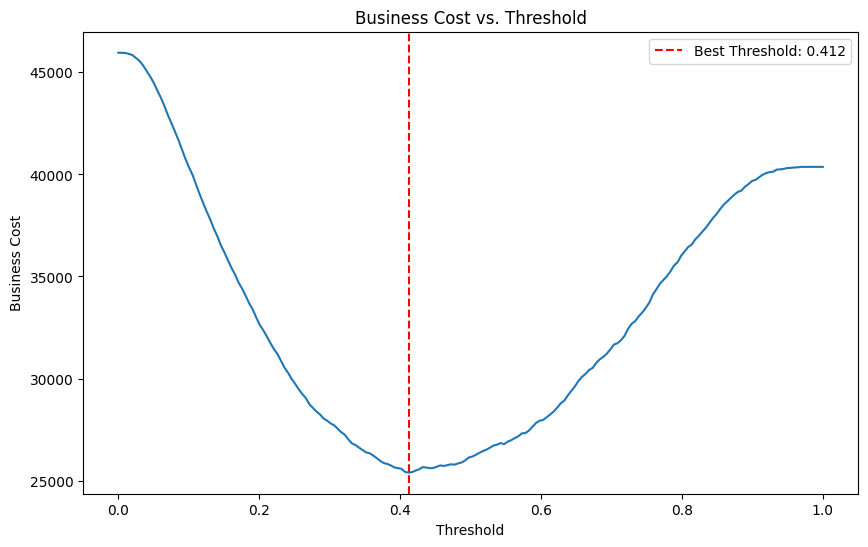

In [89]:
best_t_plot, best_c_plot = plot_cost_vs_threshold(y_sample_set, oof_proba, fn_cost=10, fp_cost=1, n=200, save_path="../reports/cost_vs_threshold.png")

In [88]:
from pathlib import Path

ART_DIR = Path("..//reports")
ART_DIR.mkdir(parents=True, exist_ok=True)

### Final train + seuil global OOF + registry

In [76]:
FN_COST = 10
FP_COST = 1

In [77]:
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_xgb_model)
])

In [78]:
#OOF proba sur FULL dataset pour seuil métier global
def oof_proba_pipeline(X, y, preprocessor, best_params, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_proba = np.zeros(len(y), dtype=float)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train = y.iloc[train_idx]

        pipe_fold = Pipeline(steps=[
            ('preprocessor', clone(preprocessor)),
            ('model', XGBClassifier(**best_params))
        ])
        pipe_fold.fit(X_train, y_train)
        oof_proba[val_idx] = pipe_fold.predict_proba(X_val)[:, 1]

        print(f"Fold {fold} done.")
    return oof_proba

In [79]:
type(best_threshold), best_threshold

(function,
 <function __main__.best_threshold(y_true, y_proba, fn_cost=10, fp_cost=1, n=200)>)

In [80]:
oof_proba_full = oof_proba_pipeline(X, y, preprocessor, best_params, n_splits=5, random_state=42)
best_t_full, best_c_full = best_threshold(y, oof_proba_full, fn_cost=FN_COST, fp_cost=FP_COST)
print(f"Optimal global FULL threshold: {best_t_full:.3f} with business cost : {best_c_full:.0f}")


Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.
Optimal global FULL threshold: 0.518 with business cost : 149159


In [81]:
y_pred_full = (oof_proba_full >= best_t_full).astype(int)
tn, fp, fn, tp = confusion_matrix(y, y_pred_full).ravel()

In [82]:
metrics_full = {
    "roc_auc": roc_auc_score(y, oof_proba_full),
    "accuracy": accuracy_score(y, y_pred_full),
    "recall": recall_score(y, y_pred_full),
    "f1_score": f1_score(y, y_pred_full),
    "business_cost": float(best_c_full),
    "best_threshold": float(best_t_full),
    "tn": float(tn), "fp": float(fp), "fn": float(fn), "tp": float(tp)
}

print("Final Model Metrics on FULL dataset:")
print(metrics_full)
print("Best Threshold:", best_t_full)
print("Best cost:", best_c_full)


Final Model Metrics on FULL dataset:
{'roc_auc': 0.7879970558733549, 'accuracy': 0.7502512154273914, 'recall': 0.6761329305135951, 'f1_score': 0.30416149462258424, 'business_cost': 149159.0, 'best_threshold': 0.5175879396984925, 'tn': 213921.0, 'fp': 68759.0, 'fn': 8040.0, 'tp': 16785.0}
Best Threshold: 0.5175879396984925
Best cost: 149159.0


In [83]:
# fit final model on full data
final_pipeline.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [90]:
# Log final model with MLflow + Model Registry
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient

mlflow.set_experiment("home-credit-scoring")

MODEL_NAME = "XGBoost_Home_Credit_Scoring"

# Signature + input example
input_example = X.iloc[:5].copy()
proba1 = pd.Series(final_pipeline.predict_proba(input_example)[:,1], name="proba_default")
signature = infer_signature(input_example, proba1)

with mlflow.start_run(run_name="Final_XGBoost_Full_Data"):
    #tags
    mlflow.set_tag(
        "mlflow.note.content",
        "Model final entrainé sur full data set 307K. XGBoost tuné avec Optuna (20 trials),"
        "Déséquilibre géré via scale_pos_weight. Seuil global OOF optimisé pour business const (FN=10, FP=1)"
    )

    mlflow.set_tags({
        "model_family":  "XGBoost",
        "data_scope": "full_data_307K",
        "objective": "minimize_business_cost",
        "fn_cost": str(FN_COST),
        "fp_cost": str(FP_COST),
        "threshold_method": "global_optimal_full_data_oof",
    })
    # log params
    mlflow.log_params(best_params)

    # log metrics
    mlflow.log_metrics(metrics_full)

    # log threshold
    mlflow.log_param("best_threshold", float(best_t_full))

    # log model
    model_info =mlflow.sklearn.log_model(
        sk_model=final_pipeline,
        artifact_path="model",
        registered_model_name=MODEL_NAME,
        signature=signature,
        input_example =input_example
    )

    print(f"Modèle final entrainé et loggé dans MLflow avec le nom '{MODEL_NAME}'.")
    print("Modèl URI:", model_info.model_uri)

/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/02/03 17:09:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Modèle final entrainé et loggé dans MLflow avec le nom 'XGBoost_Home_Credit_Scoring'.
Modèl URI: models:/m-d9343724c35148fb83a9d8efae637940


Registered model 'XGBoost_Home_Credit_Scoring' already exists. Creating a new version of this model...
Created version '3' of model 'XGBoost_Home_Credit_Scoring'.


In [93]:
# Registy metadata + alias
client = MlflowClient()

client.update_registered_model(
    name=MODEL_NAME,
    description=(
        "XGBoost pour Home Credit Default Risk "
        "Optimisé Optuna + seuil optimisé sur coût métier (FN=10, FP=1) "
        "Entraîné sur full data 307K"
    )
)

<RegisteredModel: aliases={}, creation_timestamp=1770123215252, deployment_job_id=None, deployment_job_state=None, description=('XGBoost pour Home Credit Default Risk Optimisé Optuna + seuil optimisé sur '
 'coût métier (FN=10, FP=1) Entraîné sur full data 307K'), last_updated_timestamp=1770135164439, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1770134999640, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1770134999640, metrics=[<Metric: dataset_digest=None, dataset_name=None, key='fp', model_id='m-d9343724c35148fb83a9d8efae637940', run_id='cd24b293cf6c49fdbd2e5cc67a928615', step=0, timestamp=1770134995557, value=68759.0>,
 <Metric: dataset_digest=None, dataset_name=None, key='tp', model_id='m-d9343724c35148fb83a9d8efae637940', run_id='cd24b293cf6c49fdbd2e5cc67a928615', step=0, timestamp=1770134995557, value=16785.0>,
 <Metric: dataset_digest=None, dataset_name=None, key='accuracy', model_id='m-d9343724c35148fb83a9d8efae6379

In [94]:
# récupérer la version créée (robuste)
version = getattr(model_info, "registered_model_version", None)
if version is None:
    latest = client.get_latest_versions(MODEL_NAME)
    version = sorted(latest, key=lambda v: int(v.version))[-1].version

In [97]:
# Alias pour marquer comme champion
client.set_registered_model_alias(
    name=MODEL_NAME, alias="champion", version=str(version)
)
print(f"Modèle '{MODEL_NAME}' v{version} marqué comme alias 'champion'.")

Modèle 'XGBoost_Home_Credit_Scoring' v3 marqué comme alias 'champion'.


In [99]:
versions = client.search_model_versions(f"name='{MODEL_NAME}'")
last_version = sorted(versions, key=lambda v: int(v.version))[-1].version 

In [101]:
# Passer le moidel en Staging
client.transition_model_version_stage(
    name=MODEL_NAME,
    version=last_version,
    stage="Staging",
    archive_existing_versions=True
)

print("Print moved to Staging:", MODEL_NAME, "v", last_version)

Print moved to Staging: XGBoost_Home_Credit_Scoring v 3


/var/folders/6w/kyt603rj6b11yw5nslgnnr8c0000gn/T/ipykernel_26603/3625113877.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [ ]:
# Recharger le modèle depuis le Model Registry MLflow
#import mlflow

#MODEL_NAME = "XGBoost_Home_Credit_Scoring"

#mlflow.set_tracking_uri("http://127.0.0.1:5000")

#loaded_pipeline = mlflow.sklearn.load_model(f"models:/{MODEL_NAME}/latest")

#print(type(loaded_pipeline))


<class 'sklearn.pipeline.Pipeline'>


In [ ]:
#test prediction avec le modèle rechargé
#proba = loaded_pipeline.predict_proba(X.iloc[:5])[:, 1]
#proba

2026/01/14 11:19:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


array([0.7951138 , 0.14969003, 0.3212387 , 0.2522947 , 0.53453636],
      dtype=float32)

### Feature importance local (explication d'un client) avec SHAP

In [1]:
import numpy as np
import numba
import shap

In [2]:
print(np.__version__, numba.__version__, shap.__version__)

2.3.5 0.63.1 0.50.0


In [20]:
# reconstruction preprocessor et modèle depuis le pipeline rechargé
preproc = loaded_pipeline.named_steps['preprocessor']
model = loaded_pipeline.named_steps['model']


In [21]:
# Construction de l'explainer SHAP sur échantillon
X_bg = X.sample(n=2000, random_state=42)
X_explain = X.sample(n=500, random_state=7)


In [22]:
# Transformation des données d'explication
X_bg_transformed = preproc.transform(X_bg)
X_explain_transformed = preproc.transform(X_explain)

In [23]:
# Récouparation des noms de features après préprocessing
features_names = preproc.get_feature_names_out()

In [24]:
# En DataFrame pour SHAP
X_explain_t_df = pd.DataFrame(
    X_explain_transformed.toarray () if hasattr(X_explain_transformed, "toarray") else X_explain_transformed, 
    columns=features_names,
    index=X_explain.index    
)

X_bg_t_df = pd.DataFrame(
    X_bg_transformed.toarray () if hasattr(X_bg_transformed, "toarray") else X_bg_transformed,
    columns=features_names,
    index=X_bg.index
)



In [25]:
# Creation de l'explainer SHAP TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_explain_t_df)

**Feature importance globale**

Top variables qui influencent le modèle sur l’ensemble des clients

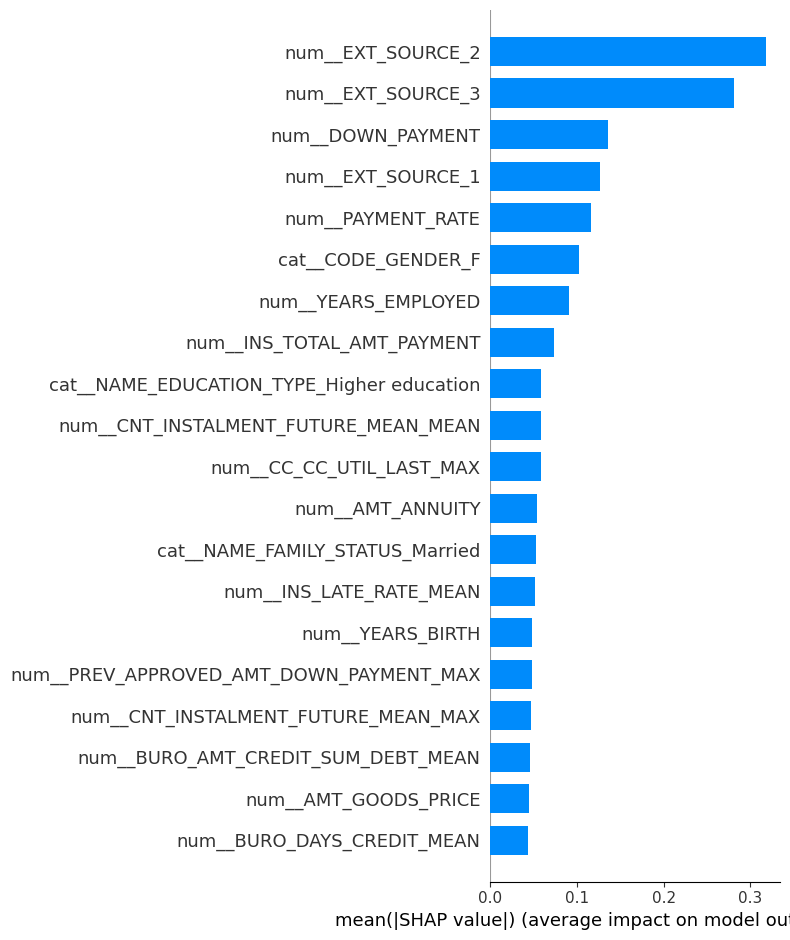

In [27]:
# Bar plot des features les plus importantes
shap.summary_plot(shap_values, X_explain_t_df, plot_type="bar", max_display=20)


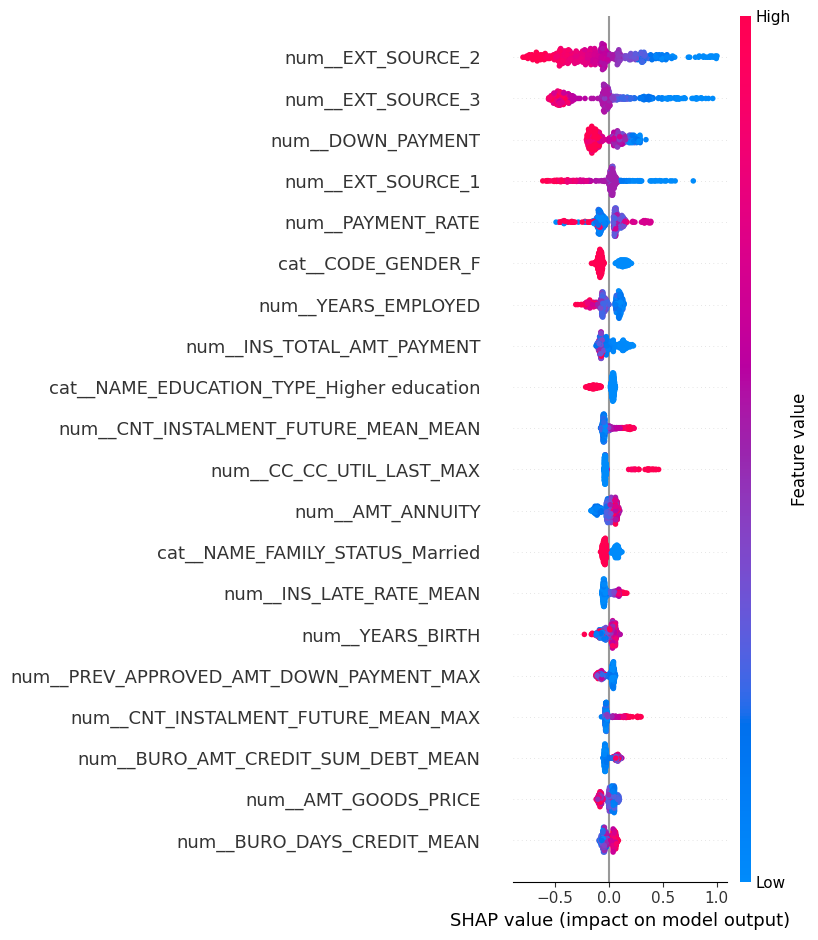

In [28]:
# Beeswarm plot des features les plus importantes
shap.summary_plot(shap_values, X_explain_t_df, max_display=20)

**Feature importance locale (un client précis)**

In [35]:
i = 5  # index de l'observation à expliquer
x_one = X_explain_t_df.iloc[[i]]
sv_one = explainer.shap_values(x_one, check_additivity=False)

base = explainer.expected_value
if isinstance(base, (list, np.ndarray)):
    base = base[0] # pour le cas binaire 

shap.initjs() 
shap.force_plot(base, sv_one[0], x_one.iloc[0])

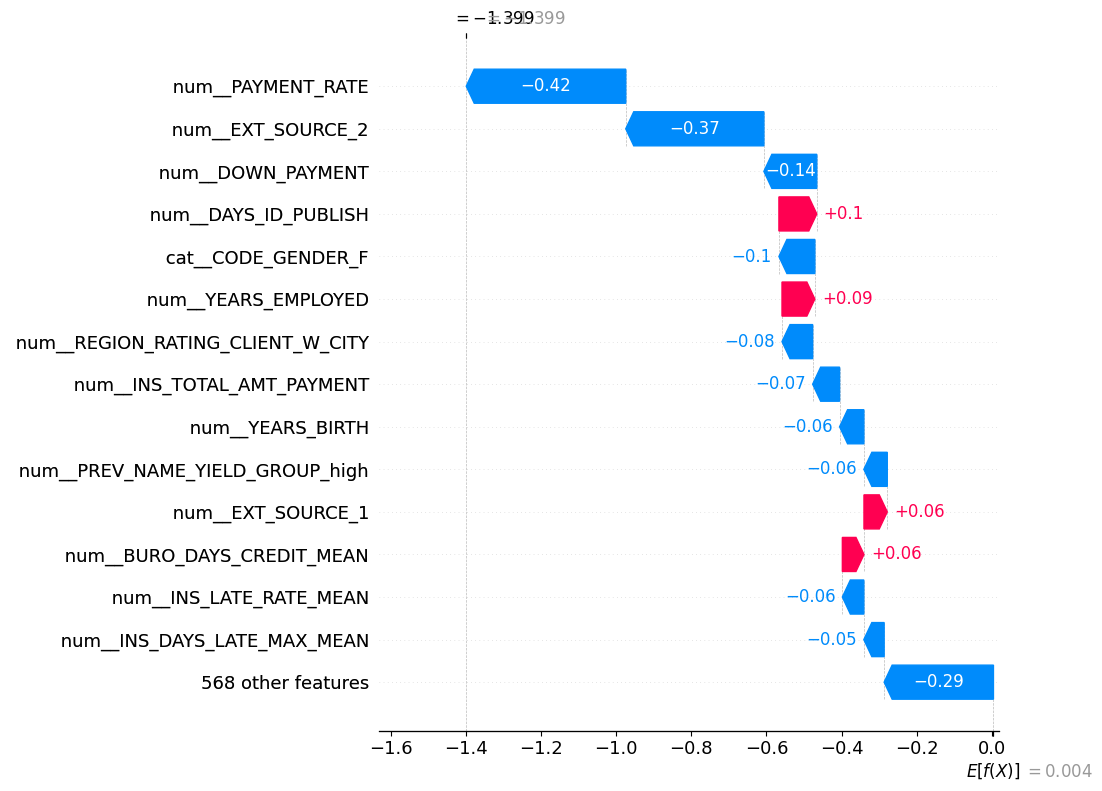

In [40]:
# Waterfall plot pour une observation
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, sv_one[0], x_one.iloc[0], max_display=15)

In [41]:
# Reletionship plot pour une seule feature

proba_client = loaded_pipeline.predict_proba(X_explain.iloc[[i]])[:, 1][0]
decision = int(proba_client >= best_t_full) # 1 si accepté, 0 sinon
print(f"Probabilité de défaut pour le client:", proba_client)
print(f"Décision du modèle au seuil {best_t_full:.3f}:", "Accepté" if decision == 0 else "Refusé") 

2026/01/14 11:46:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/kseniadautel/projet_mlops/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


NameError: name 'best_t_full' is not defined

### Export le modèle pour API

In [104]:
import joblib
import json

MODEL_NAME = "XGBoost_Home_Credit_Scoring"

OUT_DIR = Path("../src/app/artifacts")
OUT_DIR.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri("file:///Users/kseniadautel/projet_mlops/mlruns")

# charger le modèle depuis MLflow Registry
model_uri = f"models:/{MODEL_NAME}@champion"

loaded_model = mlflow.sklearn.load_model(model_uri)

# Sauver localement (dans le repo)
joblib.dump(loaded_model, OUT_DIR / "model.pkl")

# Sauver la liste des colonnes 
feature_cols = X.columns.tolist()

# Sauver la config seuil + cout + colonnes
metadata = {
    "best_threshold": 0.51775879,
    "fn_cost": 10,
    "fp_cost": 1,
    "feature_cols": feature_cols
}

(OUT_DIR / "feature_cols.json").write_text(json.dumps(feature_cols, indent=2))
(OUT_DIR / "threshold_config.json").write_text(json.dumps(metadata, indent=2))

print ("Modèle exporté dans src/app/artifacts/")



Modèle exporté dans src/app/artifacts/


In [105]:
# Creation example input (1 client ) pour envoyer à API
input_example = X.iloc[0].to_dict()


In [106]:
#remplacer Nan par None
def to_json(v):
    try:
        if v is None:
            return None
        if isinstance (v, float) and (v != v):  # NaN check
            return None
        if hasattr(np, "isnan") and isinstance(v, (np.floating, float)) and np.isnan(v):
            return None
        # numpy types -> python types
        if hasattr(v, "item"):
            return v.item()
        return v
    except Exception:
        return v

In [107]:
input_example = {k: to_json(v) for k, v in input_example.items()}

(OUT_DIR / "input_example.json").write_text(json.dumps(input_example, indent=2, ensure_ascii=False))
print("Saved:", OUT_DIR / "input_example.json")

Saved: ../src/app/artifacts/input_example.json


In [108]:
# creer un eversion 5 clients
batch = X.sample(5, random_state=42).to_dict(orient="records")
batch = [{k: to_json(v) for k, v in row.items()} for row in batch]

(OUT_DIR / "input_example_batch.json").write_text(json.dumps(batch, indent=2, ensure_ascii=False))
print("Saved:", OUT_DIR / "input_example_batch.json")

Saved: ../src/app/artifacts/input_example_batch.json


In [109]:
feature_cols = json.loads((OUT_DIR / "feature_cols.json").read_text())
missing = set(feature_cols) - set(input_example.keys())
extra = set(input_example.keys()) - set(feature_cols)
print("Missing:", list(missing)[:10], "…", len(missing))
print("Extra:", list(extra)[:10], "…", len(extra))


Missing: [] … 0
Extra: [] … 0
